# PSD Classification

- Prepare Xy
    - include only experience rows in X
    - Prepare connectivity dataset
- fit a simple svm classifier
- hyperparameters tuning (Grid search)
- model based feature selection
- feature scaling
- cross validated score
- permutation test plot
- dummy classifier for chance level
- arbitrary scores (accuracy and auc)
- permutation importance plot
- SHAP values

- baseline linear model
- select a subset of features

# Prepare Xy

In [275]:
# %conda install -c conda-forge scikit-optimize
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.linear_model import LogisticRegressionCV
import sklearn


sklearn.set_config(display='diagram')

DATA = pd.read_csv('data/classification_dataset.csv', index_col=0)
DATA = DATA.query('not condition.str.contains("baseline2")', engine='python')
# DATA = DATA.query('(description == "hypnosis" or condition == "baseline1") and procedure in ["relaxtion", "confusion"]')
DATA = DATA.sort_values(['bids_id', 'condition'])

# subtract baseline1 from each condition
X = DATA.drop(columns=['hypnosis_depth', 'procedure', 'description', 'session'])

def normalize_psd(df):
    df.set_index('condition', inplace=True)
    baseline = df.loc['baseline1']
    df = df.apply(lambda x: x - baseline, axis=1)
    return df
   
X = X.groupby('bids_id').apply(normalize_psd)
X = X.drop(columns='bids_id')
X = X.query('condition != "baseline1"')
X = X.reset_index().sort_values(['bids_id', 'condition']).drop(columns=['condition', 'bids_id'])

# Xy
DATA = DATA.query('condition != "baseline1"').reset_index()
hypnosis_depth_median = DATA['hypnosis_depth'].median()
y = DATA['hypnosis_depth'].apply(lambda x: 0 if x <= hypnosis_depth_median  else 1)

# # selecting only real hypnosis rows
DATA['proc_desc'] = DATA.apply(lambda x: f'{x["procedure"]}_{x["description"]}', axis=1)
idx1 = DATA.index[DATA['proc_desc'] == 'relaxation_hypnosis']
idx2 = DATA.index[DATA['proc_desc'] == 'confusion_hypnosis']
idx1 = idx1.append(idx2)
X = X.iloc[idx1]
y = y.iloc[idx1]

In [ ]:
# prepare connectivity data
X_conn = np.random.rand(50, 58, 58)
X_conn = np.array([xi[np.triu_indices(X_conn.shape[-1], k=0)] for xi in X_conn])

conn_labels = pd.DataFrame(columns=[f'{i}' for i in range(58)], index=[f'{i}' for i in range(58)])
conn_labels = conn_labels.apply(lambda x: x.index + '\N{left right arrow}' + x.name)
conn_labels = conn_labels.values[np.triu_indices(conn_labels.shape[0], k=0)]

# SVM

In [285]:
frontal_theta = [f for f in DATA.columns if 'F' in f and 'theta' in f]
frontal_gamma = [f for f in DATA.columns if 'F' in f and 'gamma' in f]

occi_theta = [f for f in DATA.columns if 'O' in f and 'theta' in f]
occi_gamma = [f for f in DATA.columns if 'O' in f and 'gamma' in f]

X['frontal_theta'] = DATA[frontal_theta].mean(axis=1)
X['frontal_gamma'] = DATA[frontal_gamma].mean(axis=1)
X['occi_theta'] = DATA[occi_theta].mean(axis=1)
X['occi_gamma'] = DATA[occi_gamma].mean(axis=1)

In [286]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
from sklearn.feature_selection import VarianceThreshold

# pipeline
pipe = Pipeline([
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # ('select', SelectFromModel(SVC(kernel='linear'))),
    ('reduce', 'passthrough'),
    ('clf', SVC(kernel='linear', probability=True)),
    # ('clf', DummyClassifier(strategy='uniform'))
])

Tune SVM hypreparameters using grid search

In [287]:
# hyperparameter tuning with grid search
param_grid = [
    {
        # 'scale': ['passthrough'],
        # 'select': ['passthrough'],
        # 'reduce': [PCA(n_components=i) for i in range(1, 10)],
        'clf': [SVC(probability=True)],
        'clf__C': [0.1, 1, 10, 100],
        # 'clf__gamma': [0.001, 0.0001],
        # 'clf__kernel': ['rbf', 'linear']
    },
    # {
    #     'scale': [StandardScaler(), 'passthrough'],
    #     'select': [SelectKBest()],
    #     'select__k': [10, 20, 50, 'all'],
    #     'clf': [RandomForestClassifier()],
    #     'clf__n_estimators': [10, 100]
    # }, 
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

grid = GridSearchCV(pipe, param_grid,
                    scoring=['roc_auc', 'accuracy'],
                    refit='accuracy',
                    n_jobs=-1,
                    verbose=3)



grid.fit(X_train,y_train)
pipe = grid.best_estimator_

scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

print(np.mean(scores), np.std(scores))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

[CV 5/5] END clf=SVC(probability=True), clf__C=0.1; accuracy: (test=0.688) roc_auc: (test=0.491) total time=   0.0s
[CV 1/5] END clf=SVC(probability=True), clf__C=1; accuracy: (test=0.706) roc_auc: (test=0.383) total time=   0.0s
[CV 2/5] END clf=SVC(probability=True), clf__C=0.1; accuracy: (test=0.750) roc_auc: (test=0.688) total time=   0.0s
[CV 4/5] END clf=SVC(probability=True), clf__C=0.1; accuracy: (test=0.750) roc_auc: (test=0.458) total time=   0.0s
[CV 1/5] END clf=SVC(probability=True), clf__C=0.1; accuracy: (test=0.706) roc_auc: (test=0.383) total time=   0.0s
[CV 3/5] END clf=SVC(probability=True), clf__C=0.1; accuracy: (test=0.750) roc_auc: (test=0.625) total time=   0.0s
[CV 4/5] END clf=SVC(probability=True), clf__C=1; accuracy: (test=0.750) roc_auc: (test=0.458) total time=   0.0s
[CV 5/5] END clf=SVC(probability=True), clf__C=1; accuracy: (test=0.688) roc_auc: (test=0.491) total time=   0.0s
[CV 2/5] END clf=SVC(probability=True), clf__C=10; accuracy: (test=0.812) roc_

Tune SVM hypreparameters using bayesian optimization

In [ ]:
opt = BayesSearchCV(
    pipe,
    search_spaces={'clf__C': (0.01, 100.0, 'log-uniform'),
                   'clf__gamma': (0.001, 0.1, 'log-uniform'),},
    n_iter=500,
    cv=5
)

opt.fit(X_train, y_train, callback=[skopt.callbacks.DeadlineStopper(total_time=60*2)])
opt.best_score_

In [252]:
# hyperparameter tuning with bayesian optimization
# param_space = {
#     'reduce__n_components': Integer(1, 78),
#     'clf__C': Real(0.1, 100, prior='log-uniform'),
#     'clf__gamma': Categorical('scale', 'auto'),
#     'clf__kernel': Categorical('rbf', 'linear')
# }

# # TODO: add early stopper
# opt = BayesSearchCV(pipe, param_space,
#                     scoring='accuracy',
#                     cv=5,
#                     n_jobs=-1,
#                     verbose=2,
#                     n_iter=50,
#                     n_points=2)

# opt.fit(X,
#         y,
#         # callback=[skopt.callbacks.DeadlineStopper(total_time=60 * 2)]
#         )

# opt = BayesSearchCV(
#     SVC(),
#     {
#         'C': (1e-6, 1e+6, 'log-uniform'),
#         'gamma': (1e-6, 1e+1, 'log-uniform'),
#         'degree': (1, 8),  # integer valued parameter
#         'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
#     },
#     n_iter=32,
#     cv=3,
#     n_jobs=-1
# )

# opt.fit(X, y)
# pipe = opt.best_estimator_
# print(pipe)
pipe = opt.best_estimator_

from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

print(np.mean(scores), np.std(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


0.6361328239788423 0.0381447308541559


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished


In [272]:
# permutation test
from sklearn.model_selection import permutation_test_score

obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=5, scoring='accuracy', n_permutations=100, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


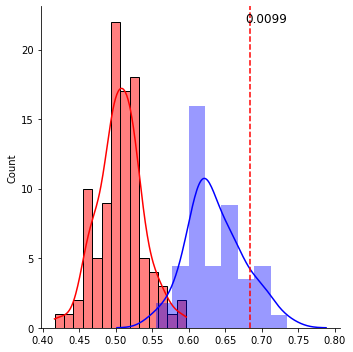

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

# TODO: improve visualization
sns.displot(perm_socres, kde=True, color='red')
sns.distplot(scores, kde=True, color='blue')
plt.axvline(obs_score, color='r', linestyle='--')
plt.annotate(f'{p_value:.4f}', xy=(obs_score, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()

In [256]:
from sklearn.inspection import permutation_importance

importances = []
for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    pipe.fit(X.iloc[train], y.iloc[train])
    perm_imp_results = permutation_importance(
        pipe, X.iloc[test], y.iloc[test], scoring='accuracy', n_repeats=2, n_jobs=-1)
    importances.append(perm_imp_results['importances'])
# TODO change n_repeats to 10 at least!!!

100%|██████████| 50/50 [00:12<00:00,  4.14it/s]


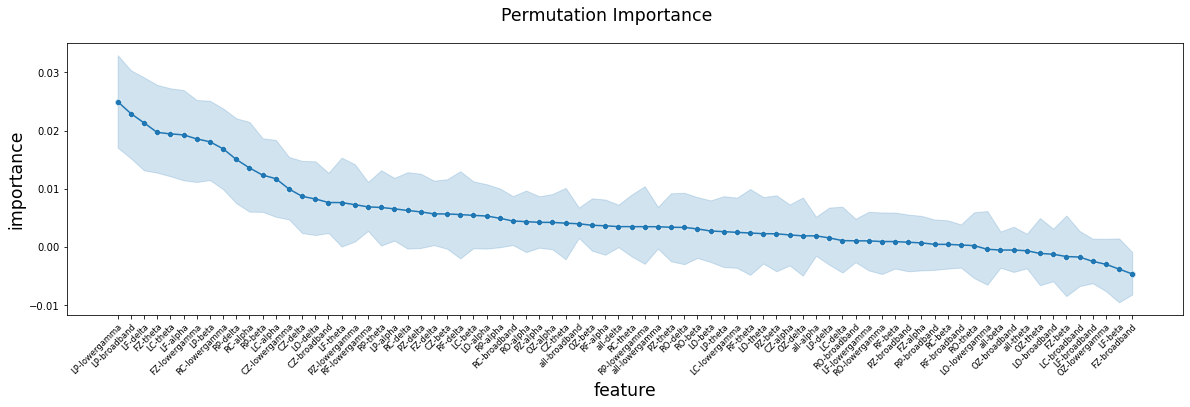

In [257]:
imp_df = pd.DataFrame(np.hstack(importances), index=X.columns)
imp_df.reset_index(inplace=True)
imp_df = imp_df.melt(id_vars=['index'])
imp_df.rename(columns={'index': 'feature', 'value': 'importance', 'variable': 'repetition'}, inplace=True)
imp_df['mean_importance'] = imp_df.groupby('feature')['importance'].transform('mean')
imp_df.sort_values(by='mean_importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(20, 5))
# sns.barplot(x='importance', y='feature', data=imp_df, orient='h', ax=ax, )
sns.lineplot(x='feature', y='importance', data=imp_df, ax=ax, ci=95)
sns.scatterplot(x='feature', y='mean_importance', data=imp_df, ax=ax)
plt.xticks(rotation=45, fontsize='small', rotation_mode='anchor', ha='right')
plt.xlabel('feature', fontsize='xx-large')
plt.ylabel('importance', fontsize='xx-large')
plt.suptitle('Permutation Importance', fontsize='xx-large')
plt.show()

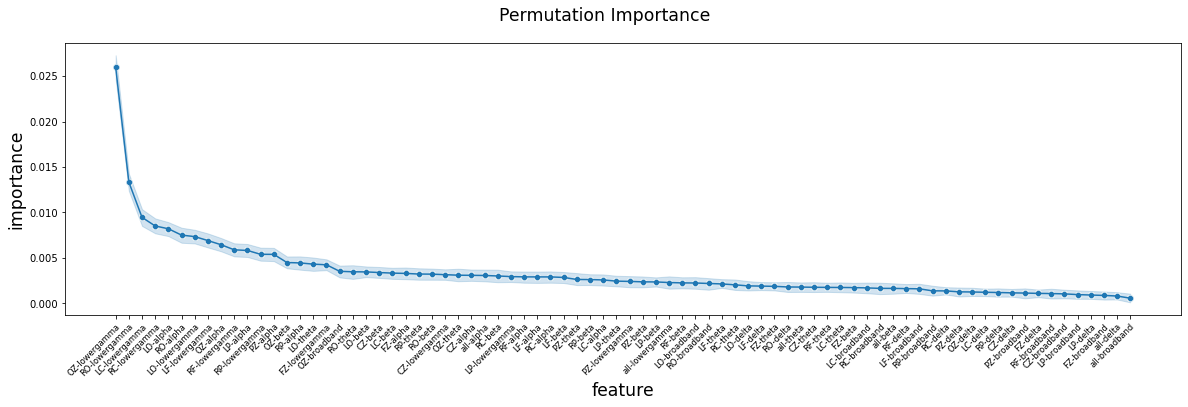

In [33]:
imp_df = pd.DataFrame(np.hstack(importances), index=X.columns)
imp_df.reset_index(inplace=True)
imp_df = imp_df.melt(id_vars=['index'])
imp_df.rename(columns={'index': 'feature', 'value': 'importance', 'variable': 'repetition'}, inplace=True)
imp_df['mean_importance'] = imp_df.groupby('feature')['importance'].transform('mean')
imp_df.sort_values(by='mean_importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(20, 5))
# sns.barplot(x='importance', y='feature', data=imp_df, orient='h', ax=ax, )
sns.lineplot(x='feature', y='importance', data=imp_df, ax=ax, ci=95)
sns.scatterplot(x='feature', y='mean_importance', data=imp_df, ax=ax)
plt.xticks(rotation=45, fontsize='small', rotation_mode='anchor', ha='right')
plt.xlabel('feature', fontsize='xx-large')
plt.ylabel('importance', fontsize='xx-large')
plt.suptitle('Permutation Importance', fontsize='xx-large')
plt.show()

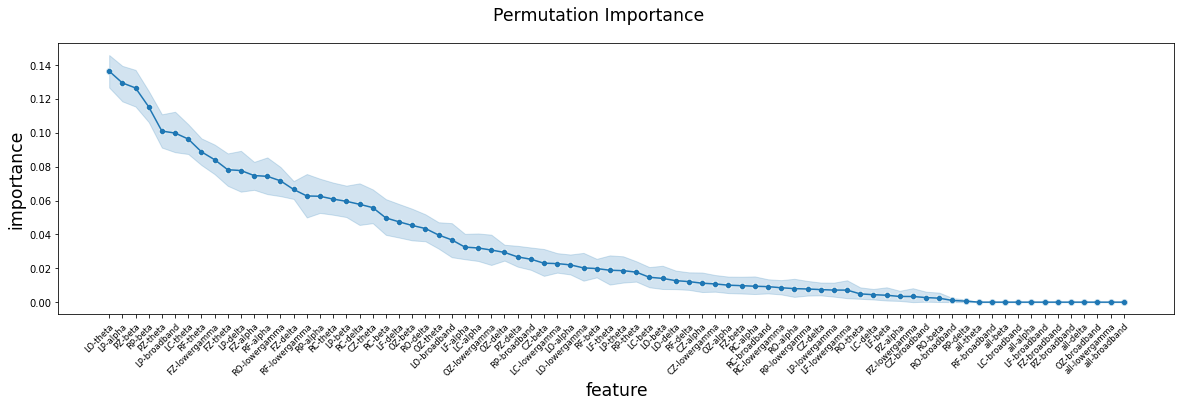

In [7]:
imp_df = pd.DataFrame(np.hstack(importances), index=X.columns)
imp_df.reset_index(inplace=True)
imp_df = imp_df.melt(id_vars=['index'])
imp_df.rename(columns={'index': 'feature', 'value': 'importance', 'variable': 'repetition'}, inplace=True)
imp_df['mean_importance'] = imp_df.groupby('feature')['importance'].transform('mean')
imp_df.sort_values(by='mean_importance', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(20, 5))
# sns.barplot(x='importance', y='feature', data=imp_df, orient='h', ax=ax, )
sns.lineplot(x='feature', y='importance', data=imp_df, ax=ax, ci=95)
sns.scatterplot(x='feature', y='mean_importance', data=imp_df, ax=ax)
plt.xticks(rotation=45, fontsize='small', rotation_mode='anchor', ha='right')
plt.xlabel('feature', fontsize='xx-large')
plt.ylabel('importance', fontsize='xx-large')
plt.suptitle('Permutation Importance', fontsize='xx-large')
plt.show()

In [ ]:
# SHAP

# %conda install -c conda-forge shap

import shap

shap_values_cv = []
X_test_indexes_cv = []
y_test_cv = []
y_pred_cv = []

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100)
pca = PCA(n_components=pipe.named_steps['reduce'].n_components_)

for train, test in tqdm(cv.split(X, y), total=cv.get_n_splits()):
    X_train_reduced = pca.fit_transform(X.iloc[train])
    X_test_reduced = pca.fit_transform(X.iloc[test])
    pipe.fit(X.iloc[train], y.iloc[train])
    y_pred = pipe.predict(X.iloc[test])
    # TODO: check if model is a treebased one, otherwise use shap.Explainer and clf.predict_proba
    # for treebased models, use TreeExplainer and clf.named_steps['clf']
    explainer = shap.KernelExplainer(pipe.named_steps['clf'].predict_proba, data=X_train_reduced,
                                   output_names=pipe.named_steps['clf'].classes_)
    _shap_values = explainer.shap_values(X_test_reduced)
    shap_values_cv.append(_shap_values)
    X_test_indexes_cv.append(test)
    y_test_cv.append(y.iloc[test])
    y_pred_cv.append(y_pred)

In [43]:
# merge shap_values_cv into a single shap values array

X_test = X.iloc[np.hstack(X_test_indexes_cv)]
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

shap_values = shap.Explanation(
    values=np.vstack([sh.values for sh in shap_values_cv]),
    base_values=np.vstack([sh.base_values for sh in shap_values_cv]),
    data=np.vstack([sh.data for sh in shap_values_cv]),
    feature_names=shap_values_cv[0].feature_names,
    output_names=shap_values_cv[0].output_names,
    output_indexes=y_pred
)

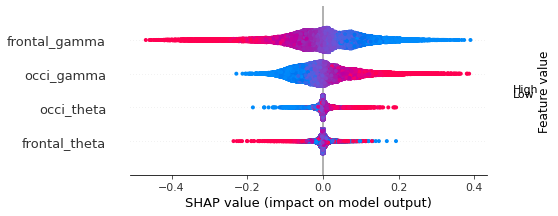

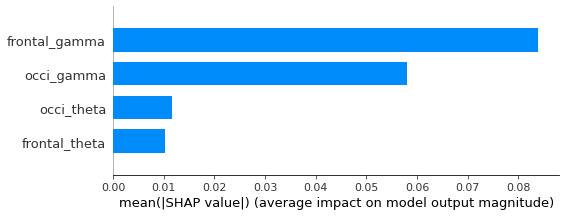

In [44]:
shap.summary_plot(shap_values.values[..., 1], X_test, max_display=10)
shap.summary_plot(shap_values.values[..., 1], X_test, plot_type='bar')

In [ ]:
explainer = shap.KernelExplainer(pipe.predict_proba, data=X_train,
                                   output_names=pipe.named_steps['clf'].classes_)
_shap_values = explainer.shap_values(X_test)

# shap.initjs()
# shap.plots.force(0.52, shap_values[1], X)
# shap.force_plot(.52, shap_values.values[..., 1], feature_names=X.columns, matplotlib=False)

In [ ]:
# TODO find a way to set the base value from the explainer.expected_value in permuted explainer

In [ ]:
misclassified = np.where(y_test != y_pred)[0]
misclassified = shap.utils.sample(misclassified, 10, random_state=None)

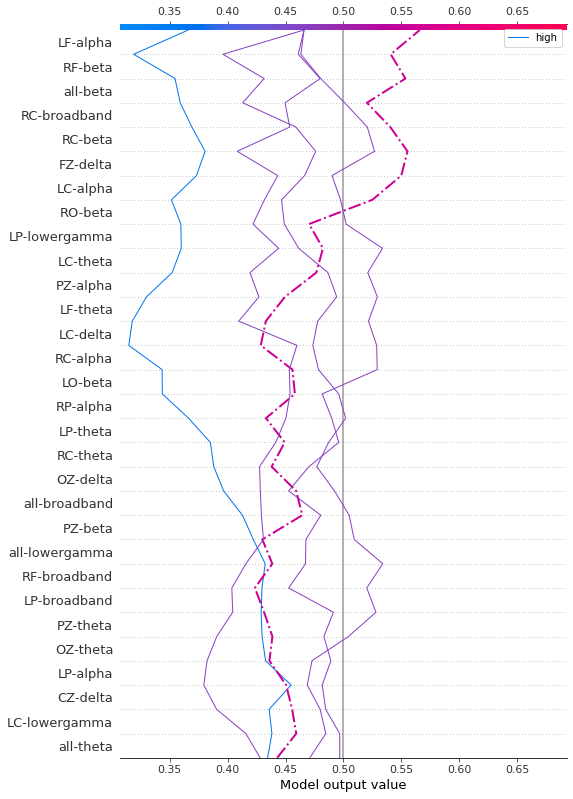

In [160]:
shap.plots.decision(.50,
                    shap_values.values[misclassified, :, 1],
                    X,
                    feature_display_range=slice(-1, -31, -1),
                    highlight=y.values[misclassified] == 'high',
                    legend_labels=['high'])

# Logistic Regression

In [ ]:
# classify with logistic regression
from sklearn.linear_model import LogisticRegressionCV

# gamma, alpha and theta averaged over the whole scalp
# TODO using mixed model with 
X = pd.DataFrame()
frontal_theta = [f for f in DATA.columns if 'F' in f and 'theta' in f]
frontal_gamma = [f for f in DATA.columns if 'F' in f and 'gamma' in f]

occi_theta = [f for f in DATA.columns if 'O' in f and 'theta' in f]
occi_gamma = [f for f in DATA.columns if 'O' in f and 'gamma' in f]

X['frontal_theta'] = DATA[frontal_theta].mean(axis=1)
X['frontal_gamma'] = DATA[frontal_gamma].mean(axis=1)
X['occi_theta'] = DATA[occi_theta].mean(axis=1)
X['occi_gamma'] = DATA[occi_gamma].mean(axis=1)

pipe = Pipeline([
    ('scale', StandardScaler()),
    # ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('reduce', PCA()),
    # ('clf', SVC(kernel='linear', probability=True)),
    ('clf', LogisticRegressionCV()),
    # ('clf', DummyClassifier(strategy='uniform'))
])

scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

print(np.mean(scores), np.std(scores))

In [269]:
# permutation test
from sklearn.model_selection import permutation_test_score

obs_score, perm_socres, p_value = permutation_test_score(
    pipe, X, y, cv=5, scoring='roc_auc', n_permutations=100, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


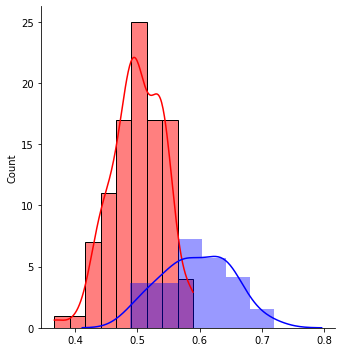

In [270]:
import seaborn as sns
import matplotlib.pyplot as plt

# TODO: improve visualization
sns.displot(perm_socres, kde=True, color='red')
sns.distplot(scores, kde=True, color='blue')
# plt.axvline(obs_score, color='r', linestyle='--')
# plt.annotate(f'{p_value:.4f}', xy=(obs_score, 0.95), xycoords='axes fraction', fontsize=12)
plt.show()